# Chapter 12

## Load packages / modules

Standard library:
- Printf for string formatting
- Statistics for the mean function

External:
- CSV to load CSV files
- DataFrames.jl for tabular data
- CategoricalArrays.jl for working with categorical data columns
- GLM.jl for models
- CairoMakie.jl for plotting
- PyCall.jl for using the Python Statsmodels package
- Distributions.jl for PDF values of Normal distributions

In [1]:
using Printf, Statistics
using CSV, DataFrames, CategoricalArrays, GLM, CairoMakie, PyCall, Distributions

## Load data

In [2]:
nhefs_all = DataFrame(CSV.File("nhefs.csv"));

Look at a couple basic details

In [3]:
size(nhefs_all)

(1629, 64)

In [4]:
names(nhefs_all)

64-element Vector{String}:
 "seqn"
 "qsmk"
 "death"
 "yrdth"
 "modth"
 "dadth"
 "sbp"
 "dbp"
 "sex"
 "age"
 "race"
 "income"
 "marital"
 ⋮
 "active"
 "exercise"
 "birthcontrol"
 "pregnancies"
 "cholesterol"
 "hightax82"
 "price71"
 "price82"
 "tax71"
 "tax82"
 "price71_82"
 "tax71_82"

Set a few columns as categorical, so they're handled correctly by GLM models

In [5]:
for s in [:education, :exercise, :active, :seqn]
    nhefs_all[!, s] = categorical(nhefs_all[!, s])
end

## Section 12.1

### Program 12.1

"We restricted the analysis to NHEFS individuals with known sex, age, race, ..." (pg 149, margin)

In [6]:
restriction_cols = [
    :sex, :age, :race, :wt82, :ht, :school, :alcoholpy, :smokeintensity
]
nhefs = dropmissing(nhefs_all, restriction_cols);

In [7]:
size(nhefs)

(1566, 64)

Average weight gains in quitters and non-quitters:

In [8]:
ave_gain_quit = mean(nhefs[nhefs.qsmk .== 1, :wt82_71])
ave_gain_noquit = mean(nhefs[nhefs.qsmk .== 0, :wt82_71])

println("Average weight gain")
@printf "      quitters: %0.1f kg\n" ave_gain_quit
@printf "  non-quitters: %0.1f kg" ave_gain_noquit

Average weight gain
      quitters: 4.5 kg
  non-quitters: 2.0 kg

Create a simple linear model to get a confidence interval on weight difference.

In [9]:
ols = lm(@formula(wt82_71 ~ qsmk), nhefs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk

Coefficients:
──────────────────────────────────────────────────────────────────────
               Coef.  Std. Error     t  Pr(>|t|)  Lower 95%  Upper 95%
──────────────────────────────────────────────────────────────────────
(Intercept)  1.9845     0.228829  8.67    <1e-16    1.53565    2.43334
qsmk         2.54058    0.45108   5.63    <1e-07    1.6558     3.42537
──────────────────────────────────────────────────────────────────────

In [10]:
est = coef(ols)[2]
lo, hi = confint(ols)[2, 1], confint(ols)[2, 2]

println("        estimate   95% C.I.")
@printf "difference   %6.2f   (%0.1f, %0.1f)" est lo hi

        estimate   95% C.I.
difference     2.54   (1.7, 3.4)

Add some columns to help calculate Table 12.1

In [11]:
nhefs.university = (nhefs.education .== 5)
nhefs.inactive = (nhefs.active .== 2)
nhefs.no_exercise = (nhefs.exercise .== 2);

Create Table 12.1 in the margin of pg 149.

In [12]:
# transpose method from
# https://github.com/JuliaData/DataFrames.jl/issues/2065#issuecomment-568937464
# https://stackoverflow.com/a/59485866

function transpose_df(df::AbstractDataFrame)::DataFrame
    DataFrame(
        [[names(df)]; collect.(eachrow(df))], [:column; Symbol.(axes(df, 1))]
    )
end

transpose_df (generic function with 1 method)

In [13]:
# calculate values
table = combine(
    groupby(nhefs, :qsmk),
    :age => mean => "Age, years",    # i.e., take the mean of :age and call it "Age, years"
    :sex => (x -> mean(100 * (x .== 0))) => "Men, %",
    :race => (x -> mean(100 * (x .== 0))) => "White, %",
    :university => (x -> 100 * mean(x)) => "University education, %",
    :wt71 => mean => "Weight, kg",
    :smokeintensity => mean => "Cigarettes/day",
    :smokeyrs => mean => "Years smoking",
    :no_exercise => (x -> 100 * mean(x)) => "Little or no exercise, %",
    :inactive => (x -> 100 * mean(x)) => "Inactive daily life, %",
)

# rearrange, rename, etc
table = table[!, Not(:qsmk)]
table = round.(table; digits=1)
table = transpose_df(table)
table = rename(
    table[!, [1, 3, 2]],
    :1 => "Mean baseline characteristics",
    :2 => "A = 1",
    :3 => "A = 0",
)

,Mean baseline characteristics,A = 1,A = 0
,String,Float64,Float64
1,"Age, years",46.2,42.8
2,"Men, %",54.6,46.6
3,"White, %",91.1,85.4
4,"University education, %",15.4,9.9
5,"Weight, kg",72.4,70.3
6,Cigarettes/day,18.6,21.2
7,Years smoking,26.0,24.1
8,"Little or no exercise, %",40.7,37.9
9,"Inactive daily life, %",11.2,8.9


## Section 12.2

### Program 12.2

We're going to be creating a lot of IP weights from logistic regressions so a function will help reduce the work. The following function creates the denominators of the IP weights.

In [14]:
"""
    logit_ip_f(spec, data, y_name=:qsmk)

Create the f(y|X) part of IP weights from logistic regression

# Arguments
- `spec::FormulaTerm`: model formula
- `data::DataFrame`: data to fit model
- `y_name::Symbol`: name of outcome variable in `data` and `spec`

# Returns
- `Array`: IP weights

"""
function logit_ip_f(spec, data, y_name=:qsmk)
    model = glm(spec, data, Binomial(), LogitLink())

    y_vals = data[!, y_name]
    pred_y = predict(model, data)
    pred_y0 = pred_y[y_vals .== 0]
    pred_y1 = pred_y[y_vals .== 1]

    weights = zeros(size(data, 1))
    weights[y_vals .== 1] = pred_y1
    weights[y_vals .== 0] = (1 .- pred_y0)
    weights
end;

In [15]:
spec = @formula(
    qsmk ~ sex
         + race 
         + age + age^2
         + education
         + smokeintensity + smokeintensity^2
         + smokeyrs + smokeyrs^2
         + exercise
         + active
         + wt71 + wt71^2
)
denoms = logit_ip_f(spec, nhefs)
weights = 1 ./ denoms;

In [16]:
println("IP weights")
@printf "   min: %5.2f   expected:  1.05\n" minimum(weights)
@printf "   max: %5.2f   expected: 16.70\n" maximum(weights)
@printf "  mean: %5.2f   expected:  2.00" mean(weights)

IP weights
   min:  1.05   expected:  1.05
   max: 16.70   expected: 16.70
  mean:  2.00   expected:  2.00

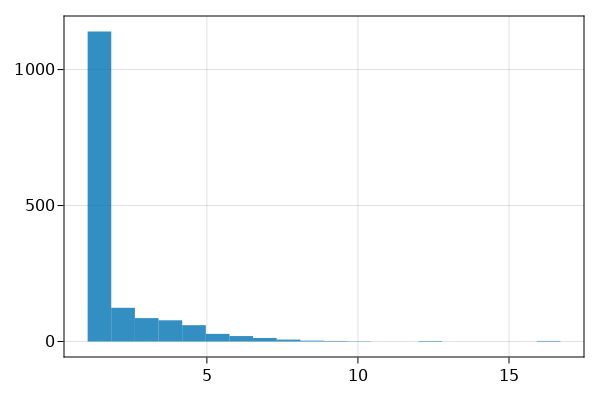

In [17]:
hist(weights, bins=20, figure=(resolution=(600, 400),))

Now, the main model

Without clustering, weighted least squares (WLS) gives the right coefficients, but the standard error is off.

In [18]:
wls = glm(@formula(wt82_71 ~ qsmk), nhefs, Normal(), IdentityLink(), wts=weights)

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Normal{Float64}, IdentityLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk

Coefficients:
───────────────────────────────────────────────────────────────────────
               Coef.  Std. Error      z  Pr(>|z|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────
(Intercept)  1.77998    0.203939   8.73    <1e-17    1.38027    2.17969
qsmk         3.44053    0.288623  11.92    <1e-32    2.87484    4.00622
───────────────────────────────────────────────────────────────────────

(The standard errors above also differ slightly from the results in Python using Statsmodels.)

It doesn't seem to be possible to use clustering directly in Julia GLM models, and there doesn't seem to be an implementation of GEE in Julia. It's preferable to use native Julia packages when they exist, but when they don't, you can use PyCall.jl or RCall.jl to use packages from Python or R installations.

We'll use Statsmodels for any model that uses clustering in covariance estimation. Statsmodels will need to be installed for whichever Python executable that PyCall is using. The [PyCall GitHub page](https://github.com/JuliaPy/PyCall.jl) describes how to install Python packages.

In [19]:
sm = pyimport("statsmodels.api");

In [20]:
# we'll pass X and y as separate values, instead of using 
# formula syntax
y = nhefs.wt82_71
X = [ones(nrow(nhefs)) nhefs.qsmk];

Here is the full output for the statsmodels version of the model above (i.e., still without clustering).

In [21]:
wls = sm.WLS(y, X, weights=weights)
res = wls.fit()
sry = res.summary(xname=["(Intercept)", "qsmk"])

PyObject <class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.044
Model:                            WLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     71.14
Date:                Mon, 20 Dec 2021   Prob (F-statistic):           7.47e-17
Time:                        23:07:41   Log-Likelihood:                -5613.4
No. Observations:                1566   AIC:                         1.123e+04
Df Residuals:                    1564   BIC:                         1.124e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
(Intercept)     1.7800      0.288      6.175      0.000       1.215       2.345
qsmk            3.4405      0.408      8.434      0.000       2.640       4.241
==============================================================================
Omnibus:                      209.379   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1901.742
Skew:                           0.281   Prob(JB):                         0.00
Kurtosis:                       8.369   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<br>
There's a lot of useful information in this output, but in these notebooks we'll focus on the middle portion, the coefficients and confidence intervals. The function below will display just that portion.

In [22]:
function display_coefs(sm_results; xname=nothing)
    sm_summary = sm_results.summary(xname=xname)
    tables = split(sm_summary.as_html(), "</table>\n<table")
    display("text/html", "<table" * tables[2] * "</table>")
end;

In [23]:
display_coefs(res, xname=["(Intercept)", "qsmk"])

,coef,std err,t,P>|t|,[0.025,0.975]
(Intercept),1.7800,0.288,6.175,0.000,1.215,2.345
qsmk,3.4405,0.408,8.434,0.000,2.640,4.241


The version above, which estimates covariance without clustering, has standard errors that are too small.

With clustering, GEE and WLS give the right coefficients and better standard errors. Unfortunately, Statsmodel's GEE doesn't currently work through PyCall.

WLS with clustering:

In [24]:
# PyCall seems to have trouble converting a categorical column
# into a Python object
groups = convert(Array{Int}, nhefs.seqn);

In [25]:
wls = sm.WLS(y, X, weights=weights)
res = wls.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [26]:
display_coefs(res, xname=["(Intercept)", "qsmk"])

,coef,std err,z,P>|z|,[0.025,0.975]
(Intercept),1.7800,0.225,7.915,0.000,1.339,2.221
qsmk,3.4405,0.526,6.543,0.000,2.410,4.471


In [27]:
est = res.params[2]
conf_ints = res.conf_int(alpha=0.05)
lo, hi = conf_ints[2, 1], conf_ints[2, 2]

println("           estimate   95% C.I.")
@printf "theta_1     %6.2f   (%0.1f, %0.1f)" est lo hi

           estimate   95% C.I.
theta_1       3.44   (2.4, 4.5)

Here's a simple check that there is no association between `sex` and `qsmk`.

In [28]:
qsmk = nhefs.qsmk
sex = nhefs.sex
DataFrame(
    sex=[0, 1],
    qsmk_0=[
        sum(weights[(qsmk .== 0) .& (sex .== 0)]),
        sum(weights[(qsmk .== 0) .& (sex .== 1)])
    ],
    qsmk_1=[
        sum(weights[(qsmk .== 1) .& (sex .== 0)]),
        sum(weights[(qsmk .== 1) .& (sex .== 1)])
    ],
)

,sex,qsmk_0,qsmk_1
,Int64,Float64,Float64
1,0,763.608,763.623
2,1,801.749,797.2


In [29]:
subset_indices = (nhefs.race .== 0) .& (nhefs.sex .== 1)
subset = nhefs[subset_indices, :];

Now a check for positivity

In [30]:
# counts of qsmk x age
age_grouped = groupby(subset[!, [:age, :qsmk]], :age)
qsmk_1 = combine(age_grouped, :qsmk => sum).qsmk_sum
qsmk_0 = combine(age_grouped, nrow => :count).count .- qsmk_1;

In [31]:
age = sort(unique(subset.age));

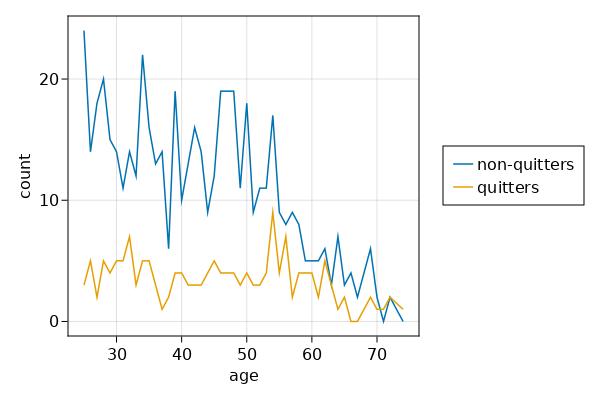

In [32]:
fig = Figure(resolution=(600, 400)) 
ax = Axis(fig[1, 1], xlabel="age", ylabel="count")

line1 = lines!(ax, age, qsmk_0)
line2 = lines!(ax, age, qsmk_1)

Legend(fig[1, 2], [line1, line2], ["non-quitters", "quitters"])

fig

There are a few combinations of qsmk x age with zero counts:

In [33]:
DataFrame(age=age, qsmk_0=qsmk_0, qsmk_1=qsmk_1)[end-9:end, :]

,age,qsmk_0,qsmk_1
,Int64,Int64,Int64
1,63,3,3
2,64,7,1
3,65,3,2
4,66,4,0
5,67,2,0
6,69,6,2
7,70,2,1
8,71,0,1
9,72,2,2


For a discussion on cells with zero counts, see Fine Point 12.2, pg 155.

## Section 12.3

"The effect estimate obtained in the pseudo-population created by weights $0.5 \, / \, f(A|L)$
is equal to that obtained in the pseudo-population created by weights $1 \, / \, f(A|L)$."

In [34]:
wls = sm.WLS(y, X, weights=(0.5 .* weights))
res = wls.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [35]:
display_coefs(res, xname=["(Intercept)", "qsmk"])

,coef,std err,z,P>|z|,[0.025,0.975]
(Intercept),1.7800,0.225,7.915,0.000,1.339,2.221
qsmk,3.4405,0.526,6.543,0.000,2.410,4.471


"Second, we need to estimate Pr[A=1] for the numerator of the weights. We can obtain a nonparametric estimate by the ratio 403/1566 or, equivalently, by fitting a saturated logistic model for Pr[A=1] with an intercept and no covariates." pg 154

In [36]:
qsmk = (nhefs.qsmk .== 1);

In [37]:
# option 1
qsmk_mean = mean(qsmk)
qsmk_mean

0.25734355044699875

In [38]:
# option 2
# note this is using GLM.jl not Python Statsmodels
lgt = glm(@formula(qsmk ~ 1), nhefs, Binomial(), LogitLink())

StatsModels.TableRegressionModel{GeneralizedLinearModel{GLM.GlmResp{Vector{Float64}, Binomial{Float64}, LogitLink}, GLM.DensePredChol{Float64, LinearAlgebra.Cholesky{Float64, Matrix{Float64}}}}, Matrix{Float64}}

qsmk ~ 1

Coefficients:
─────────────────────────────────────────────────────────────────────────
                Coef.  Std. Error       z  Pr(>|z|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)  -1.05982   0.0578034  -18.33    <1e-74   -1.17311  -0.946529
─────────────────────────────────────────────────────────────────────────

In [39]:
lgt_pred = predict(lgt);

Check for equivalence

In [40]:
equivalent = isapprox(lgt_pred, qsmk_mean .* ones(nrow(nhefs)))
println("equivalent: ", equivalent)

equivalent: true


### Program 12.3

Create stabilized IP weights. Shortcut: modify the IP weights already calculated.

In [41]:
s_weights = zeros(nrow(nhefs))
s_weights[qsmk] = mean(qsmk) * weights[qsmk]    # `qsmk` was defined a few cells ago
s_weights[.! qsmk] = mean(1 .- qsmk) * weights[.! qsmk];

In [42]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(s_weights) mean(s_weights) maximum(s_weights)

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.30

Refit the model from the last section, using the new weights

In [43]:
wls = sm.WLS(y, X, weights=s_weights)
res = wls.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [44]:
display_coefs(res, xname=["(Intercept)", "qsmk"])

,coef,std err,z,P>|z|,[0.025,0.975]
(Intercept),1.7800,0.225,7.915,0.000,1.339,2.221
qsmk,3.4405,0.526,6.543,0.000,2.410,4.471


In [45]:
est = res.params[2]
conf_ints = res.conf_int(alpha=0.05)
lo, hi = conf_ints[2, 1], conf_ints[2, 2]

println("           estimate   95% C.I.")
@printf "theta_1     %6.2f   (%0.1f, %0.1f)" est lo hi

           estimate   95% C.I.
theta_1       3.44   (2.4, 4.5)

The estimate is the same as in the previous section

We can check again for no association between sex and qsmk in the the pseudo-population

In [46]:
qsmk = nhefs.qsmk
sex = nhefs.sex
DataFrame(
    sex=[0, 1],
    qsmk_0=[
        sum(s_weights[(qsmk .== 0) .& (sex .== 0)]),
        sum(s_weights[(qsmk .== 0) .& (sex .== 1)])
    ],
    qsmk_1=[
        sum(s_weights[(qsmk .== 1) .& (sex .== 0)]),
        sum(s_weights[(qsmk .== 1) .& (sex .== 1)])
    ],
)

,sex,qsmk_0,qsmk_1
,Int64,Float64,Float64
1,0,567.098,196.513
2,1,595.424,205.154


## Section 12.4

### Program 12.4

Subset the data to subjects that smoked 25 or fewer cigarettes per day at baseline. In this case, we can either obtain the subset from the original dataset, or we can obtain it from the reduced dataset that we've been using. I'll get it from the reduced subset.

In [47]:
# from original dataset

good_rows = (nhefs_all.smokeintensity .<= 25) .& .! ismissing.(nhefs_all.wt82)
intensity25 = nhefs_all[good_rows, :]
size(intensity25)

(1162, 64)

In [48]:
# from reduced dataset

intensity25 = nhefs[nhefs.smokeintensity .<= 25, :]
size(intensity25)

(1162, 67)

Create the stabilized IP weights $SW^A = f(A) \, / \, f(A|L)$

"we assumed that the density f(A|L) was normal (Gaussian) with mean $\mu = E[A|L]$ and variance $\sigma^2$.  We then used a linear regression model to estimate the mean $E[A|L]$ and variance of residuals $\sigma^2$ for all combinations of values of L." pg 156


In [49]:
spec = @formula(
    smkintensity82_71 ~ sex
                      + race 
                      + age + age^2
                      + education
                      + smokeintensity + smokeintensity^2
                      + smokeyrs + smokeyrs^2
                      + exercise
                      + active
                      + wt71 + wt71^2
)

ols = lm(spec, intensity25);

In [50]:
A = intensity25.smkintensity82_71;

In [51]:
A_pred = predict(ols, intensity25);   # i.e., E[A|L]

The denominator is the distribution, $N(\mu, \sigma)$, evaluated at each point of $y = A$.

In [52]:
mse_resid = sum((A - A_pred) .^ 2) / dof_residual(ols)  # variance
fAL = [
    pdf(Normal(a_pred, sqrt(mse_resid)), a)
    for (a, a_pred) in zip(A, A_pred)
];

"We also assumed that the density f(A) in the numerator was normal."

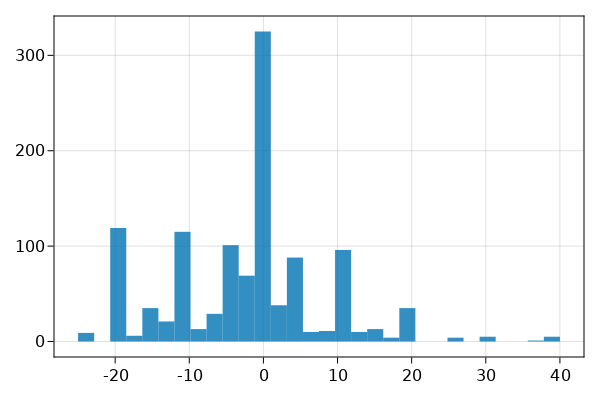

In [53]:
hist(A, bins=30, figure=(resolution=(600, 400),))

In [54]:
mean(A), std(A)

(-2.057659208261618, 10.467830908151857)

In [55]:
a_dist = Normal(mean(A), std(A))
fA = [pdf(a_dist, a) for a in A];

Then the stabilized IP weights are

In [56]:
sw = fA ./ fAL;

In [57]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(sw) mean(sw) maximum(sw)

Stabilized weights
 min   mean    max
------------------
0.19   1.00   5.10

Now fit the marginal structural model

In [58]:
y = intensity25.wt82_71
X = [ones(nrow(intensity25)) A A.^2]   # A = intensity25.smkintensity82_71
groups = convert(Array{Int}, intensity25.seqn);

In [59]:
wls = sm.WLS(y, X, weights=sw)
res = wls.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [60]:
display_coefs(res, xname=["(Intercept)", "A", "A^2"])

,coef,std err,z,P>|z|,[0.025,0.975]
(Intercept),2.0045,0.296,6.783,0.000,1.425,2.584
A,-0.1090,0.032,-3.452,0.001,-0.171,-0.047
A^2,0.0027,0.002,1.113,0.266,-0.002,0.007


To get the estimate and confidence interval for "no change", you can read off the values in the `constant` row above (because `A` and `A^2` will be zero).

To calculate the estimate and confidence interval for when smoking increases by 20 cigarettes / day we'll use the `get_prediction` method on the Python model object.

There are three versions below that just modify the presentation by using extra knowledge of the underlying Python objects. 

In [61]:
# version 1: basic

pred_inputs = [
    1  0  0  ;    # no change in smoking intensity
    1 20 20^2     # plus 20 cigarettes / day
]
pred = res.get_prediction(exog=pred_inputs)
summary = pred.summary_frame()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,2.004525,0.295502,1.425351,2.583698,-13.243053,17.252103
1,0.902723,1.310533,-1.665873,3.471320,-14.548842,16.354289


In [62]:
# version 2: simplify

summary = summary.round(1)
summary = summary.__getitem__(["mean", "mean_ci_lower", "mean_ci_upper"])
# Using __getitem__ is not the standard way to do this in Python

,mean,mean_ci_lower,mean_ci_upper
0,2.0,1.4,2.6
1,0.9,-1.7,3.5


In [63]:
# version 3: relabel the rows and columns

summary.index = ["no change", "+20 per day"]
summary.columns = ["estimate", "CI lower", "CI upper"]
summary

,estimate,CI lower,CI upper
no change,2.0,1.4,2.6
+20 per day,0.9,-1.7,3.5


### Program 12.5

"if interested in the causal effect of quitting smoking A (1: yes, 0: no) on the risk of death D (1: yes, 0: no) by 1982, one could consider a _marginal structural logistic model_"

In [64]:
y = nhefs.death
X = [ones(nrow(nhefs)) nhefs.qsmk]
groups = convert(Array{Int}, nhefs.seqn);

In [65]:
lgt = sm.GLM(y, X, freq_weights=s_weights, family=sm.families.Binomial())
res = lgt.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [66]:
display_coefs(res, xname=["(Intercept)", "qsmk"])

,coef,std err,z,P>|z|,[0.025,0.975]
(Intercept),-1.4905,0.079,-18.869,0.000,-1.645,-1.336
qsmk,0.0301,0.157,0.191,0.848,-0.278,0.339


Odd ratio is $\exp(\hat{\theta}_1)$

In [67]:
est = exp(res.params[2])
conf_ints = res.conf_int(alpha=0.05)
lo = exp(conf_ints[2, 1])
hi = exp(conf_ints[2, 2])

println("           estimate   95% C.I.")
@printf "odds ratio  %6.2f   (%0.1f, %0.1f)" est lo hi

           estimate   95% C.I.
odds ratio    1.03   (0.8, 1.4)

## Section 12.5

### Program 12.6

Create the numerator of the IP weights. Reuse the basic `weights` for the denominator.

In [68]:
spec = @formula(qsmk ~ sex)
numer = logit_ip_f(spec, nhefs);

In [69]:
sw_AV = numer .* weights;

In [70]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(sw_AV) mean(sw_AV) maximum(sw_AV)

Stabilized weights
 min   mean    max
------------------
0.29   1.00   3.80

In [71]:
y = nhefs.wt82_71
X = [ones(nrow(nhefs)) nhefs.qsmk nhefs.sex nhefs.qsmk .* nhefs.sex]
groups = convert(Array{Int}, nhefs.seqn);

In [72]:
wls = sm.WLS(y, X, weights=sw_AV)
res = wls.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [73]:
display_coefs(res, xname=["(intercept)", "qsmk", "sex", "qsmk & sex"])

,coef,std err,z,P>|z|,[0.025,0.975]
(intercept),1.7844,0.310,5.752,0.000,1.176,2.393
qsmk,3.5220,0.658,5.353,0.000,2.232,4.811
sex,-0.0087,0.449,-0.019,0.985,-0.890,0.872
qsmk & sex,-0.1595,1.047,-0.152,0.879,-2.212,1.893


The last line gives the estimate $\hat{\theta}_2$ = -0.2 and confidence interval (-2.2, 1.9).

## Section 12.6

### Program 12.7

We're going back to the original dataset

In [74]:
size(nhefs_all)

(1629, 64)

We'll add a feature to track censored individuals

In [75]:
nhefs_all.censored = ismissing.(nhefs_all.wt82);

Create the IP weights for treatment

In [76]:
spec = @formula(
    qsmk ~ sex
         + race
         + education
         + exercise
         + active
         + age + age ^ 2
         + wt71 + wt71 ^ 2
         + smokeintensity + smokeintensity ^ 2
         + smokeyrs + smokeyrs ^ 2
)
ip_denom = logit_ip_f(spec, nhefs_all);

In [77]:
ip_numer = zeros(nrow(nhefs_all))
ip_numer[nhefs_all.qsmk .== 0] .= mean(nhefs_all.qsmk .== 0)
ip_numer[nhefs_all.qsmk .== 1] .= mean(nhefs_all.qsmk .== 1);

In [78]:
sw_A = ip_numer ./ ip_denom;

In [79]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(sw_A) mean(sw_A) maximum(sw_A)

Stabilized weights
 min   mean    max
------------------
0.33   1.00   4.21

Now the IP weights for censoring

In [80]:
spec = @formula(
    censored ~ sex
             + race
             + education
             + exercise
             + active
             + age + age ^ 2
             + wt71 + wt71 ^ 2
             + smokeintensity + smokeintensity ^ 2
             + smokeyrs + smokeyrs ^ 2
             + qsmk
)
ip_denom = logit_ip_f(spec, nhefs_all, :censored);

In [81]:
spec = @formula(censored ~ qsmk)
ip_numer = logit_ip_f(spec, nhefs_all, :censored);

In [82]:
sw_C = ip_numer ./ ip_denom
sw_C[nhefs_all.censored .== 1] .= 1;

In [83]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(sw_C) mean(sw_C) maximum(sw_C)

Stabilized weights
 min   mean    max
------------------
0.94   1.00   1.72

Now create the combined IP weights

In [84]:
sw_AC = sw_A .* sw_C;

In [85]:
println("Stabilized weights")
println(" min   mean    max")
println("------------------")
@printf "%04.2f   %04.2f   %04.2f" minimum(sw_AC) mean(sw_AC) maximum(sw_AC)

Stabilized weights
 min   mean    max
------------------
0.35   1.00   4.09

Now model weight gain using the combined IP weights

In [86]:
y = nhefs.wt82_71
X = [ones(nrow(nhefs)) nhefs.qsmk]
groups = convert(Array{Int}, nhefs.seqn);

In [87]:
wls = sm.WLS(y, X, weights=sw_AC[nhefs_all.censored .== 0])
res = wls.fit(cov_type="cluster", cov_kwds=Dict("groups" => groups));

In [88]:
display_coefs(res, xname=["(intercept)", "qsmk"])

,coef,std err,z,P>|z|,[0.025,0.975]
(intercept),1.6620,0.233,7.136,0.000,1.206,2.118
qsmk,3.4965,0.526,6.648,0.000,2.466,4.527
